### Double-well potential

In this section, 

According to the supplemntary materials of the paper, the equation of the double-well potential is $E(x, y) = ax^{4}-bx^{2}+cx+dy^{2}$
Therefore, we have:
$$\frac{\partial E}{\partial x} = 4ax^{3}-2bx+c=0, \;\frac{\partial E}{\partial y}=dy=0$$
By default, $a=1$, $b=6$, $c=1$, and $d=1$. Solving the equations above,  so the three places with a 0 derivative along with their potential are:
$(-1.7723, 0, -10.7524)$, $(0.08253, 0, 0.0417)$, and $(1.6888, 0, -7.2893)$. Accordingly, the energy difference between the wells is $3.463$.


In [1]:
import numpy as np
import potentials
import sampling
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The coordinates of the minima are: [-1.7723034076580755, 0.0] and [1.6887758209615107, 0.0].
The coordinate of the saddle point is: [0.08352758669656443, 0.0].
The energy difference between the two local minima is: 3.463.
The height of energy barrier is: 10.794.


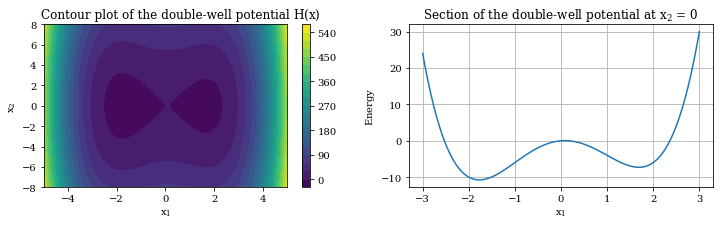

In [2]:
doublewell = potentials.DoubleWellPotential()  #  defaults = {"a": 1, "b": 6, "c": 1, "d": 1}
# another choice: a=0.25, b=1.5, c=1, d=1
doublewell.plot_samples()
print('The coordinates of the minima are: %s and %s.' % (list(doublewell.min_left), list(doublewell.min_right)))
print('The coordinate of the saddle point is: %s.' % list(doublewell.saddle))
print('The energy difference between the two local minima is: %5.3f.' % doublewell.e_diff)
print('The height of energy barrier is: %5.3f.' % doublewell.barrier)

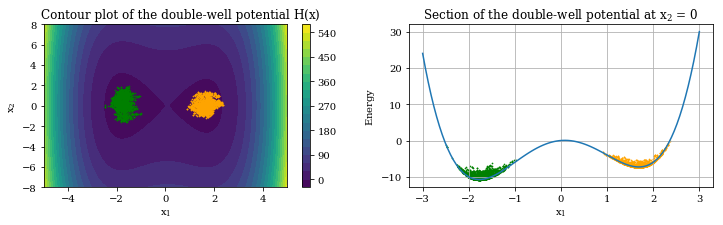

In [5]:
MCsampler1 = sampling.MetropolisSampler(doublewell, doublewell.min_left)
MCsampler1.run(doublewell.min_left, 2000)
samples1 = MCsampler1.xtraj

MCsampler2 = sampling.MetropolisSampler(doublewell, doublewell.min_right)
MCsampler2.run(doublewell.min_right, 2000)
samples2 = MCsampler2.xtraj

fig = doublewell.plot_samples(samples1)
fig = doublewell.plot_samples(samples2, fig, 'orange')